In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
from scipy import integrate as integrate
import pandas as pd
from scipy.optimize import minimize

In [2]:
c = 2.99792458e+5
omega_v0 = 0.0014
omega_bh2 = 0.02305

In [3]:
def E(z, parameters):   
    omega_k0, omega_m0,h0 = parameters
    h=h0/100
    omega_cb0 = omega_m0 - omega_v0
    #omega=(omega_bh2+omega_ch2+omega_vh2)/h**2
    return ((omega_m0*((1+z)**3)) + omega_k0*((1+z)**2) + 1 - omega_m0 - omega_k0)**(1/2)
def f(z,parameters):
    return 1/E(z,parameters)

In [1]:
def Chi_sq1(parameters,H_obs,z_obs,sigma_obs):
    n = z_obs.shape[0]
    H_theo = np.zeros(n)
    omega_k0,omega_m0,Ho = parameters
    chi_sq=0
    for i in range(n):
        H_theo[i]= Ho*(E(z_obs[i],parameters))
        chi_sq= chi_sq+(H_obs[i]-H_theo[i])**2/(sigma_obs[i])**2
    return chi_sq

In [5]:
np.sin(0)

0.0

In [6]:
def dH(parameters,z):
    omega_k0,omega_m0,Ho = parameters
    return c/(Ho*E(z,parameters))
def dC(parameters,z):
    omega_k0,omega_m0,Ho = parameters
    return (c/Ho)*integrate.quad(f,0,(z),args=(parameters,))[0]
def dM(parameters,z):
    omega_k0,omega_m0,Ho = parameters
    if omega_k0 == 0:
        return dC(parameters,z)
    elif omega_k0 > 0:
        return (c / (Ho*np.sqrt(omega_k0)))*np.sinh(np.sqrt(omega_k0)*Ho*dC(parameters,z) / c)
    elif omega_k0 < 0:
        mod_omega_k0 = -omega_k0
        return (c / (Ho*np.sqrt(mod_omega_k0)))*np.sin(np.sqrt(mod_omega_k0)*Ho*dC(parameters,z) / c)
def dA(parameters,z):
    return dM(parameters,z)/(1+z)
def dV(parameters,z):
    Ho = parameters[2]
    return (((c/Ho)*((dM(parameters,z))**2)*(z/E(z,parameters)))**(1/3))

In [7]:
def rs(parameters,z):
    omega_k0,omega_m0,Ho = parameters
    h = Ho/100
    num =np.exp(-72.3*(omega_v0*h**2+0.0006)**2)
    den = ((omega_bh2)**(0.12807))*(((omega_m0 - omega_v0)*h**2)**(0.25351))
    return 55.154*num/den

In [8]:
def Chi_sq2(parameters,D_obs,z_obs,cov_mat):
    datapoints= z_obs.shape
    D_theo= np.zeros(datapoints)
    Ho=parameters[2]
    
    dm_indices= [0,2,4]
    h_indices=[3,1,5]
    Dv_indices = [6,8]
    dA_indices = [7]
    dhrs_indices = [9]
    dmrs_indices = [10]
    
    rs_fid= 147.78
    
    for i in Dv_indices:
        if i==6:
            D_theo[i]= dV(parameters,z_obs[i])*147.5/rs(parameters,z_obs[i])
        else:
            D_theo[i]= dV(parameters,z_obs[i])*rs_fid/rs(parameters,z_obs[i])
    for i in h_indices:
        D_theo[i]=Ho*E(z_obs[i],parameters)*rs(parameters,z_obs[i])/rs_fid
    for i in dm_indices:
        D_theo[i]=dM(parameters,z_obs[i])*rs_fid/rs(parameters,z_obs[i])
    for i in dhrs_indices:
        D_theo[i]=(dH(parameters,z_obs[i]))/ rs(parameters,z_obs[i])
    for i in dmrs_indices:
        D_theo[i]=(dM(parameters,z_obs[i]))/ rs(parameters,z_obs[i])
    for i in dA_indices:
        D_theo[i]=(dA(parameters,z_obs[i]))/rs(parameters,z_obs[i])
    #print(parameters)
    #print("D_theo1",D_theo)
    #print("D_obs",D_obs)
    D_theo= D_theo-D_obs
    #print("D_theo",D_theo)
    A = np.matmul(np.linalg.inv(cov_mat),D_theo)
    #print("A",A)
    final = (np.matmul(D_theo.T,A))
    #print(final)
    #print(np.linalg.inv(cov_mat))
    #print(final)
    return final[0,0]

In [9]:
def Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs2,cov_matrix):
    #print(Chi_sq3(parameters,H_obs1,z_obs1,sigma_obs1))
    return (Chi_sq2(parameters,D_obs,z_obs2,cov_matrix)+ Chi_sq1(parameters,H_obs1,z_obs1,sigma_obs1))

In [10]:
def lnprior1(parameters):
    omega_k0,omega_m0,Ho = parameters
    omega_lambda = 1-omega_k0 - omega_m0
    if 0.1<=omega_m0<=0.7 and 50<=Ho<=85 and 0.2<=omega_lambda<=1:
        return 0
    return -np.inf

In [11]:
def log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    return -Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)/2

In [12]:
def log_probability(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    lp = lnprior1(parameters)
    if not np.isfinite(lp):
        return -np.inf
    #print(lp)
    #print(lp + log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix))
    return lp + log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)

In [13]:
Data = pd.read_csv("H(z) data - Sheet1.csv")
z_obs1 = Data['z']
z_obs1 = z_obs1.to_numpy()
z_obs1 = np.reshape(z_obs1,(31,1))
H_obs1 = Data['H(z)']
sigma_obs1 = Data['sigma']
print(Data)
print(z_obs1.shape)

         z   H(z)  sigma
0   0.0700   69.0   19.6
1   0.0900   69.0   12.0
2   0.1200   68.6   26.2
3   0.1700   83.0    8.0
4   0.1790   75.0    4.0
5   0.1990   75.0    5.0
6   0.2000   72.9   29.6
7   0.2700   77.0   14.0
8   0.2800   88.8   36.6
9   0.3520   83.0   14.0
10  0.3802   83.0   13.5
11  0.4000   95.0   17.0
12  0.4004   77.0   10.2
13  0.4247   87.1   11.2
14  0.4497   92.8   12.9
15  0.4700   89.0   50.0
16  0.4783   80.9    9.0
17  0.4800   97.0   62.0
18  0.5930  104.0   13.0
19  0.6800   92.0    8.0
20  0.7810  105.0   12.0
21  0.8750  125.0   17.0
22  0.8800   90.0   40.0
23  0.9000  117.0   23.0
24  1.0370  154.0   20.0
25  1.3000  168.0   17.0
26  1.3630  160.0   33.6
27  1.4300  177.0   18.0
28  1.5300  140.0   14.0
29  1.7500  202.0   40.0
30  1.9650  186.5   50.4
(31, 1)


In [14]:
Data = pd.read_csv("BAO data - Sheet1 (3).csv")
print(Data)
Data['value'][9] = 8.86
Data['value'][10] = 37.41
Data['z'][9] = 2.34
Data['z'][10] = 2.34
#print(Data)

        z      value   sigma
0   0.380  1512.3900     NaN
1   0.380    81.2087     NaN
2   0.510  1975.2200     NaN
3   0.510    90.9029     NaN
4   0.610  2306.6800     NaN
5   0.610    98.9647     NaN
6   0.122   539.0000   17.00
7   0.810    10.7500    0.43
8   1.520  3843.0000  147.00
9   2.334    37.5000     NaN
10  2.334     8.9900     NaN


In [15]:
z_obs = (Data['z'].to_numpy()).astype(float)
z_obs = np.reshape(z_obs, (11,1))
Data = Data.to_numpy()
D_obs = Data[:,1].astype(float)
D_obs = np.reshape(D_obs,(11,1))
print(z_obs.shape)
print(D_obs)

(11, 1)
[[1512.39  ]
 [  81.2087]
 [1975.22  ]
 [  90.9029]
 [2306.68  ]
 [  98.9647]
 [ 539.    ]
 [  10.75  ]
 [3843.    ]
 [   8.86  ]
 [  37.41  ]]


In [16]:
cov_matrix2 = np.matrix([[624.707, 23.729, 325.332, 8.34963, 157.386, 3.57778,0,0,0,0,0],
                    [23.729, 5.60873, 11.6429, 2.33996, 6.39263, 0.968056,0,0,0,0,0],
                    [325.332, 11.6429, 905.777, 29.3392, 515.271, 14.1013,0,0,0,0,0],
                    [8.34963, 2.33996, 29.3392, 5.42327, 16.1422, 2.85334,0,0,0,0,0],
                    [157.386, 6.39263, 515.271, 16.1422, 1375.12, 40.4327,0,0,0,0,0],
                    [3.57778, 0.968056, 14.1013, 2.85334, 40.4327, 6.25936,0,0,0,0,0],
                    [0,0,0,0,0,0,17**2,0,0,0,0],
                     [0,0,0,0,0,0,0,0.43**2,0,0,0],
                     [0,0,0,0,0,0,0,0,147**2,0,0],
                     [0,0,0,0,0,0,0,0,0,0.0841,-0.183396],
                     [0,0,0,0,0,0,0,0,0,-0.183396,3.4596]])

In [2]:
initial = np.array([0.01,0.024, 70]) 
soln = minimize(Chi_sq, initial, args=(H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix2),bounds=[(0,1),(0,1),(0,np.inf)])
print(soln)

NameError: name 'np' is not defined

In [18]:
import emcee
pos = soln.x + 1e-4 * np.random.randn(200, 3)
nwalkers, ndim = pos.shape

#filename = "BAO_LCDM.h5"
#backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix2))

sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [7:00:05<00:00,  2.52s/it]


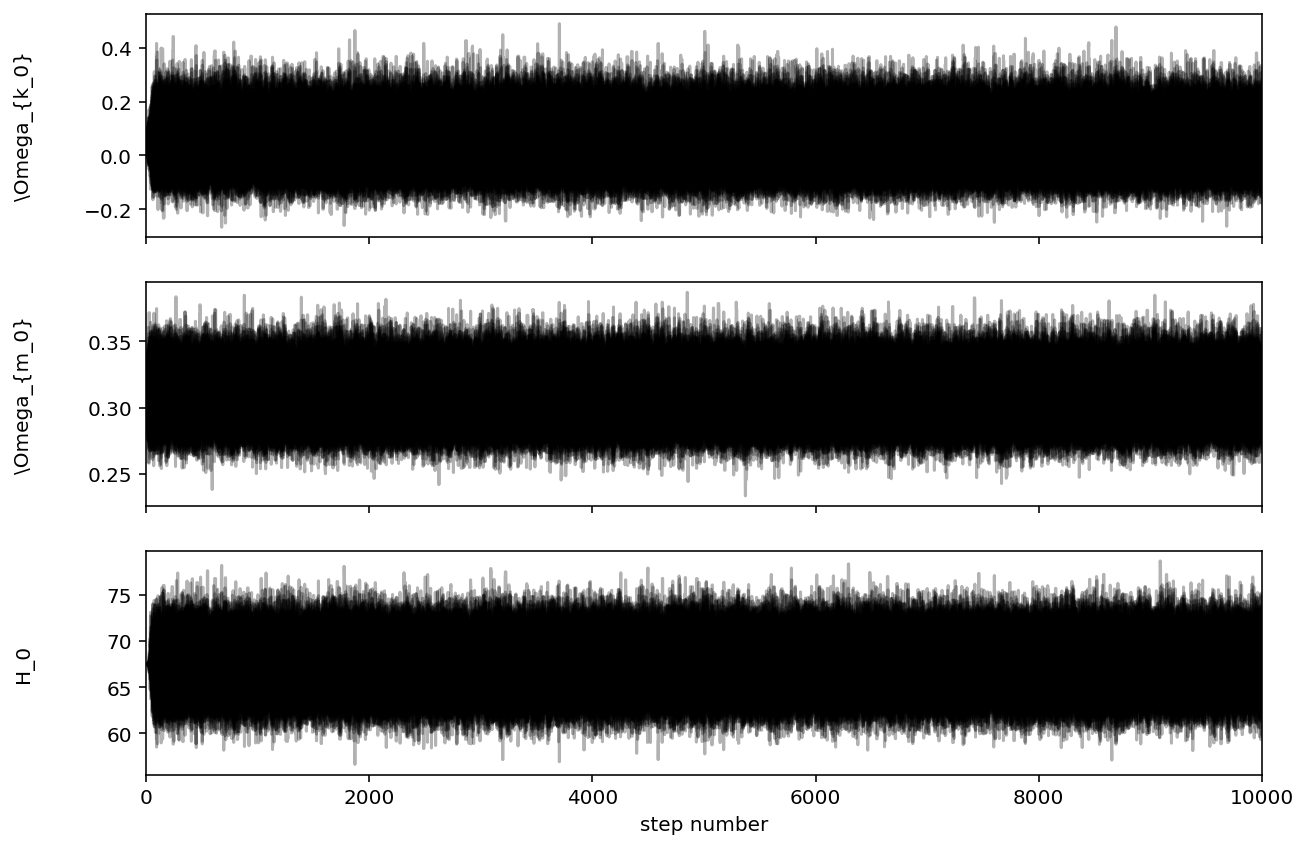

In [31]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["\Omega_{k_0}","\Omega_{m_0}", "H_0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [32]:
tau = sampler.get_autocorr_time()
print(tau)

[37.6002858  37.35256117 37.42631079]


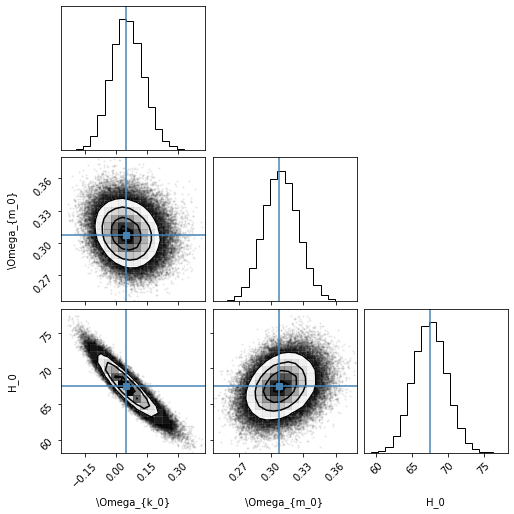

In [21]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=soln.x
);

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

GetDist Version: 1.4.3, Matplotlib version: 3.5.2


In [23]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [24]:
names = ["omega_k0","omega_m02","Ho"]
labels =  ["\Omega_{k_0}","\Omega_{m_0}", "H_0"]
samples2 = MCSamples(samples=flat_samples,names = names, labels = labels)

Removed no burn in


In [49]:
means = samples2.getMeans()
stats = samples2.getMargeStats()
conf_levels = samples2.contours
lims0 = stats.parWithName('omega_k0').limits
lims1 = stats.parWithName('omega_m02').limits
lims2 = stats.parWithName('Ho').limits

In [43]:
print(stats)
print(means)

Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
omega_k0    5.4501387E-02  7.7768538E-02  5.2047375E-02  5.2251065E-02  two   -2.7442086E-02  1.2742532E-01  two   -9.4530380E-02  2.1716286E-01  two   -1.6334615E-01  3.1068290E-01  two     \Omega_{k_0}
omega_m02   3.0937319E-01  1.5999779E-02  3.0903586E-01  3.0907601E-01  two    2.9337395E-01  3.2536695E-01  two    2.7830423E-01  3.4234415E-01  two    2.6403827E-01  3.5954183E-01  two     \Omega_{m_0}
Ho          6.7471808E+01  2.3242851E+00  6.7452719E+01  6.7458718E+01  two    6.5140646E+01  6.9800125E+01  two    6.2872352E+01  7.2142828E+01  two    6.0547503E+01  7.4661358E+01  two     H_0

[5.45013867e-02 3.09373192e-01 6.74718084e+01]


<Figure size 432x324 with 0 Axes>

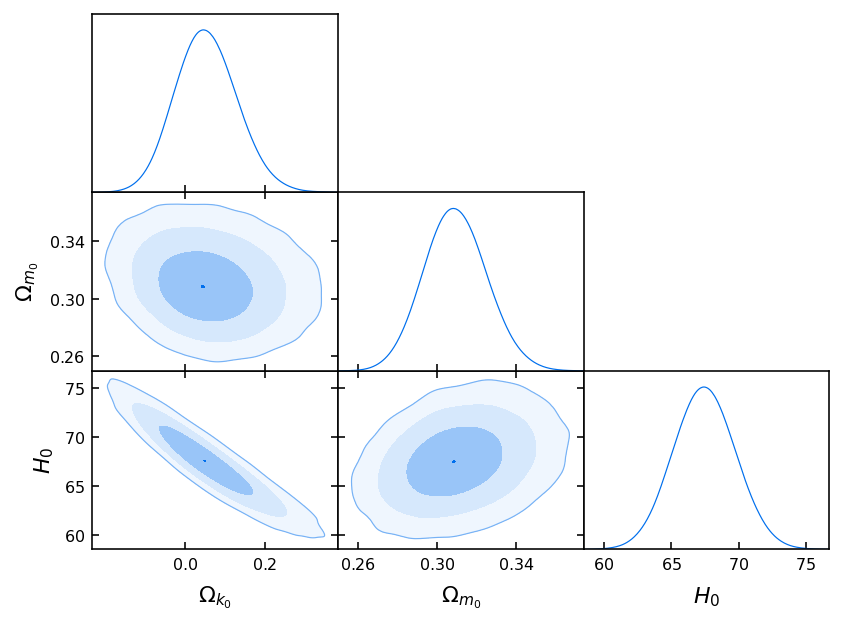

In [34]:
g = plots.get_single_plotter()

g.settings.num_plot_contours = 4
g.triangle_plot([samples2], filled=True);

In [48]:
samples2.updateSettings({'contours': [0.6827, 0.9545, 0.9973]})

In [47]:
print(lims0)

[<getdist.types.ParamLimit object at 0x000002CCCC2572C8>, <getdist.types.ParamLimit object at 0x000002CCCC3A6BC8>, <getdist.types.ParamLimit object at 0x000002CCCC3A6C88>]


In [52]:
for conf, lim0, lim1, lim2 in zip(samples2.contours,lims0,lims1,lims2):
        if conf!=0.6827:
            continue
        print('value: %.3f, lower: %.3f, upper: %.3f'%(means[0], lim0.lower - means[0], lim0.upper- means[0]))
        print('value: %.3f, lower: %.3f, upper: %.3f'%(means[1], lim1.lower - means[1], lim1.upper- means[1]))
        print('value: %.2f, lower: %.2f, upper: %.2f'%(means[2], lim2.lower - means[2], lim2.upper - means[2]))

value: 0.055, lower: -0.082, upper: 0.073
value: 0.309, lower: -0.016, upper: 0.016
value: 67.47, lower: -2.33, upper: 2.33


In [30]:
print(samples2.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\Omega_{k_0}   $} & $0.055^{+0.073}_{-0.082}   $\\

{\boldmath$\Omega_{m_0}   $} & $0.309^{+0.016}_{-0.016}   $\\

{\boldmath$H_0            $} & $67.5^{+2.3}_{-2.3}        $\\
\hline
\end{tabular}
